## Import Dependencies

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchviz import make_dot
from tqdm import tqdm

## Data Prep
Loading data from **MNist** dataset, and define image embeddings \\

In this case, we have two separated datasets, the unpartitioned and partitioned. We perform traditional training on unpartitioned dataset and perform federated learning on partitioned dataset. The partitioned dataset would be splitted into 10 parts.

In [2]:
# Define transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to range [-1, 1]
])

# Load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

## Define Model
This time we're going to try out a more complicated architecture called **ResNet**, we need to verify if the federated learning still applies on this model.

In [3]:
# Write a ResNet class with the input of 1 channel, 28x28 images and 10 labels
# Write a ResidualBlock class with 2 convolutional layers and a skip connection

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        self.layer1 = self.make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 64, layers[2], stride=2)
        self.avg_pool = nn.AvgPool2d(7)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn(self.conv(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [13]:
# Train Function
def train(model, trainloader, criterion, optimizer, epochs=5):
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')
    print('Finished Training')

# Test Function
def test(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')
    




In [14]:
# Train non-partitioned model
model = ResNet(ResidualBlock, [2, 2, 2, 2])
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train(model, trainloader, criterion, optimizer, epochs=5)
test(model, testloader)


 20%|██        | 1/5 [02:06<08:24, 126.15s/it]

Epoch 1, Loss: 0.4129909145931403


 40%|████      | 2/5 [04:08<06:12, 124.08s/it]

Epoch 2, Loss: 0.07040340384369095


 60%|██████    | 3/5 [06:08<04:03, 121.96s/it]

Epoch 3, Loss: 0.0478322117211918


 80%|████████  | 4/5 [08:02<01:58, 118.93s/it]

Epoch 4, Loss: 0.0366349396529297


100%|██████████| 5/5 [10:07<00:00, 121.56s/it]

Epoch 5, Loss: 0.03141862981542945
Finished Training


Accuracy of the network on the 10000 test images: 99.28%


In [15]:
# Partition the dataset into 5 pieces and train the model on each piece, then combine the models
# Partition the dataset
partitioned_trainset = []
partitioned_trainloader = []
for i in range(5):
    partitioned_trainset.append(torch.utils.data.Subset(trainset, list(range(i * 12000, (i + 1) * 12000))))
    partitioned_trainloader.append(torch.utils.data.DataLoader(partitioned_trainset[i], batch_size=32, shuffle=True))

# Train the models
models = []
for i in range(5):
    model = ResNet(ResidualBlock, [2, 2, 2, 2])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    train(model, partitioned_trainloader[i], criterion, optimizer, epochs=5)
    models.append(model)

# Combine the models using weighted averaging, weight should be assigned according to the loss of each model
# Calculate the loss of each model
losses = []
for i in range(5):
    loss = 0
    for data in partitioned_trainloader[i]:
        inputs, labels = data
        outputs = models[i](inputs)
        loss += criterion(outputs, labels).item()
    losses.append(loss)

# Calculate the weights
weights = []
for loss in losses:
    weights.append(loss / sum(losses))

# Combine the models
combined_model = ResNet(ResidualBlock, [2, 2, 2, 2])
combined_model.load_state_dict(models[0].state_dict())
for i in range(1, 5):
    for combined_param, param in zip(combined_model.parameters(), models[i].parameters()):
        combined_param.data += param.data * weights[i]

# Test the combined model
test(combined_model, testloader)



 20%|██        | 1/5 [00:23<01:35, 23.98s/it]

Epoch 1, Loss: 1.3920534321467082


 40%|████      | 2/5 [00:48<01:13, 24.37s/it]

Epoch 2, Loss: 0.3778120805025101


 60%|██████    | 3/5 [01:13<00:48, 24.44s/it]

Epoch 3, Loss: 0.18122433087229728


 80%|████████  | 4/5 [01:39<00:25, 25.37s/it]

Epoch 4, Loss: 0.12592378665010134


100%|██████████| 5/5 [02:04<00:00, 24.99s/it]


Epoch 5, Loss: 0.09762490177154541
Finished Training


 20%|██        | 1/5 [00:23<01:35, 23.88s/it]

Epoch 1, Loss: 1.3118236924012503


 40%|████      | 2/5 [00:48<01:12, 24.32s/it]

Epoch 2, Loss: 0.277372209529082


 60%|██████    | 3/5 [01:12<00:48, 24.12s/it]

Epoch 3, Loss: 0.1478728071252505


 80%|████████  | 4/5 [01:36<00:24, 24.02s/it]

Epoch 4, Loss: 0.1024251230408748


100%|██████████| 5/5 [02:00<00:00, 24.05s/it]


Epoch 5, Loss: 0.08056273458898068
Finished Training


 20%|██        | 1/5 [00:24<01:36, 24.05s/it]

Epoch 1, Loss: 1.4521104265848797


 40%|████      | 2/5 [00:48<01:13, 24.48s/it]

Epoch 2, Loss: 0.36720981522401175


 60%|██████    | 3/5 [01:14<00:50, 25.10s/it]

Epoch 3, Loss: 0.1814854824145635


 80%|████████  | 4/5 [01:39<00:25, 25.10s/it]

Epoch 4, Loss: 0.12986460969348748


100%|██████████| 5/5 [02:06<00:00, 25.27s/it]


Epoch 5, Loss: 0.09762289435168107
Finished Training


 20%|██        | 1/5 [00:25<01:40, 25.09s/it]

Epoch 1, Loss: 1.3857296686967213


 40%|████      | 2/5 [00:50<01:15, 25.28s/it]

Epoch 2, Loss: 0.3574479816357295


 60%|██████    | 3/5 [01:16<00:51, 25.58s/it]

Epoch 3, Loss: 0.175316257417202


 80%|████████  | 4/5 [01:42<00:25, 25.58s/it]

Epoch 4, Loss: 0.12290718768537044


100%|██████████| 5/5 [02:07<00:00, 25.44s/it]


Epoch 5, Loss: 0.0916736070116361
Finished Training


 20%|██        | 1/5 [00:26<01:47, 26.85s/it]

Epoch 1, Loss: 1.4008429895242056


 40%|████      | 2/5 [00:52<01:18, 26.33s/it]

Epoch 2, Loss: 0.341993495007356


 60%|██████    | 3/5 [01:17<00:51, 25.72s/it]

Epoch 3, Loss: 0.16905913428465524


 80%|████████  | 4/5 [01:45<00:26, 26.33s/it]

Epoch 4, Loss: 0.1174716631869475


100%|██████████| 5/5 [02:13<00:00, 26.80s/it]

Epoch 5, Loss: 0.08495847479254007
Finished Training


Accuracy of the network on the 10000 test images: 85.7%


RuntimeError: Given groups=1, weight of size [16, 1, 3, 3], expected input[1, 3, 32, 32] to have 1 channels, but got 3 channels instead

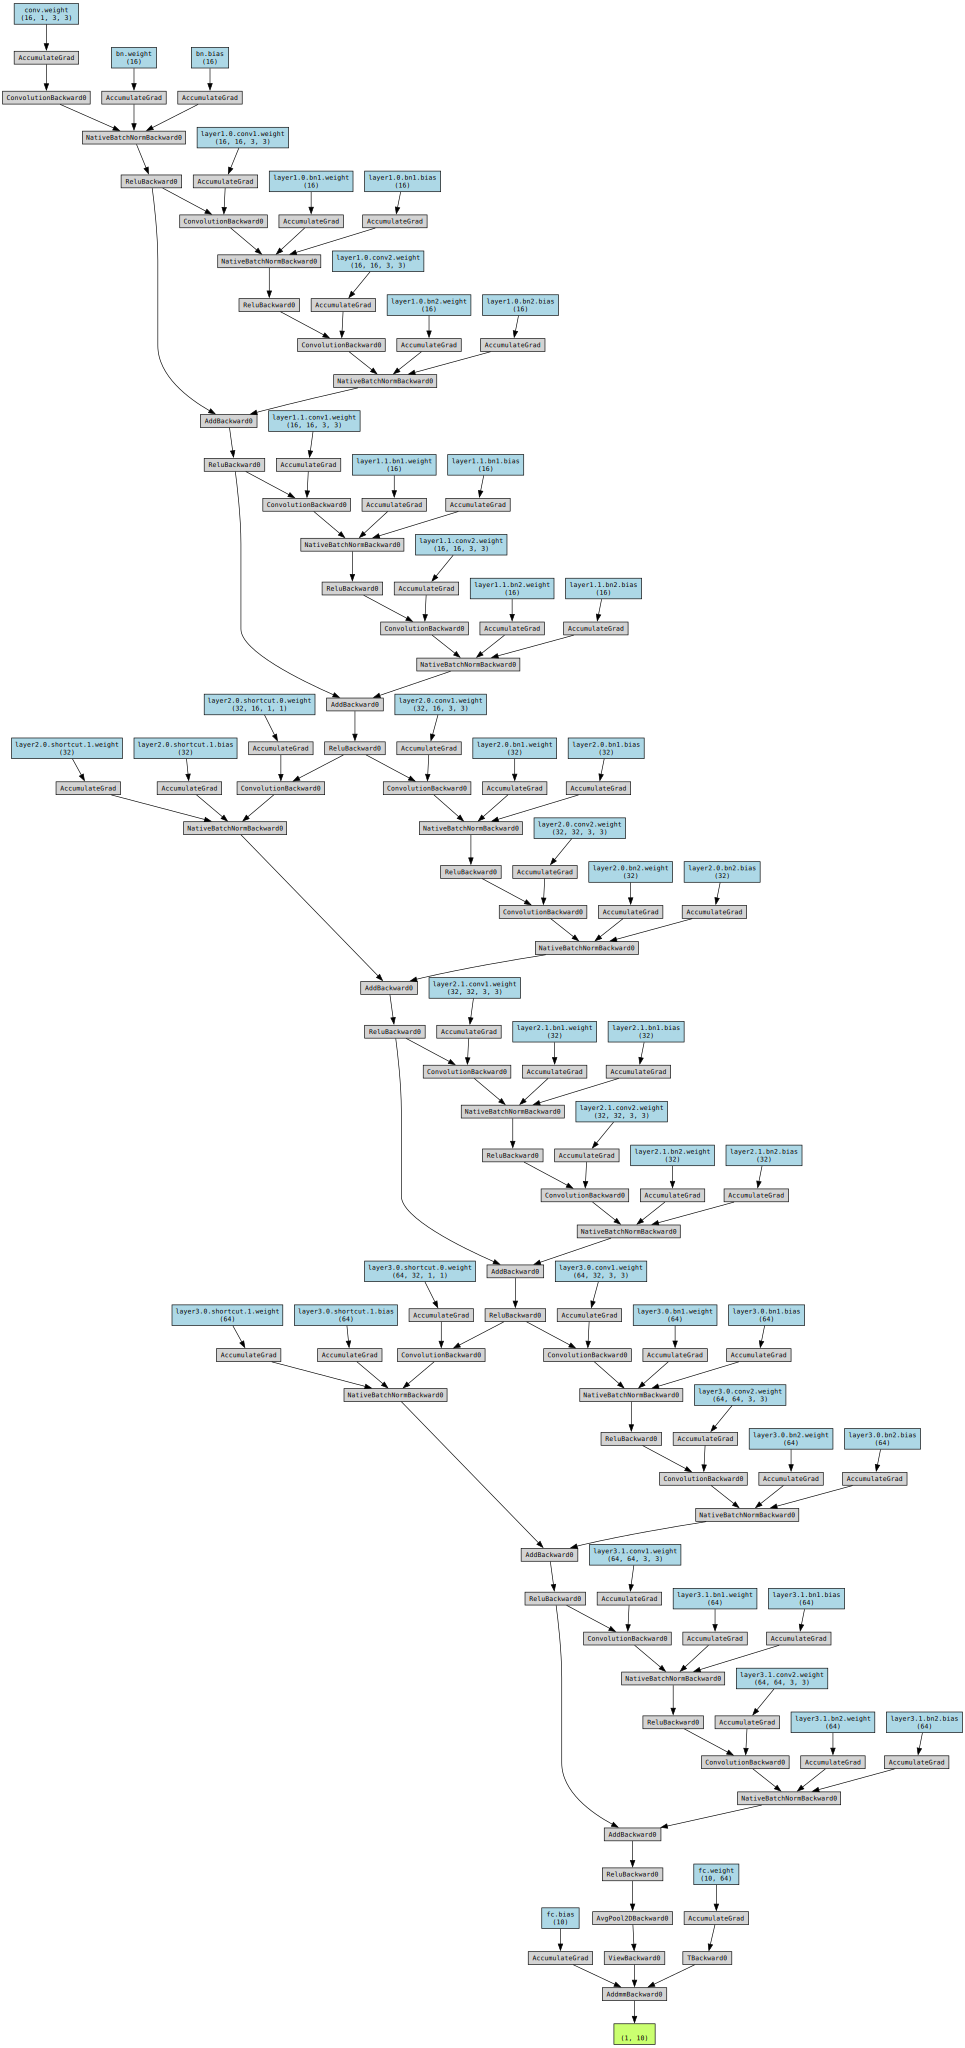

In [16]:
# Visualize the model
make_dot(combined_model(torch.randn(1, 1, 32, 32)), params=dict(combined_model.named_parameters()))